In [1]:
%matplotlib inline

<center> <b>Bayesian optimisation using scikit-optimize</b> </center>


<center>


<p> <b>Manoj Kumar</b>

<p>Feb 6, CERN


</center>

<center> <b>About me </b></center>


- Masters Student at New York University
- Core developer of sklearn
- Contributed to Spark and SymPy


#### Contact

- [GitHub](http://github.com/MechCoder)
- [@MechCoderr](http://twitter.com/MechCoderr)


<center><font size="12"> Slides: https://mechcoder.github.io/diana-talk/</font> </center>
<p>
<p>
<center><font size="12"> All presentation materials: https://github.com/MechCoder/diana-talk</font></center>


### Bayesian Optimisation

### Ingredients

- A black-box function $f^*(X)$.

- A predictive model that provides $P(Y | X)$

- An acquisition function acq(x) that uses $P(Y | X)$.

- Package(s) that takes care of all of these under the hood!

### Goal

The goal being to minimize the black-box function $f^*(X)$ 

### Tie all the ingredients together!

- Call black box $f^*(X)$ $N$ times to obtain $D$ = $(X_1, y_1), (X_2, y_2), ... (X_N, y_N)$

- For $n$ in $n_{calls}$

    - Fit model to $D$
    - Obtain $X_{c} = \underset{x}{\operatorname{argmin}}$ acq(x)
    - $D$ = concat($D, (X_c, f^*(X_c))$)
    
- Return $X_i$ for which $y_i$ is minimum.

### scikit-optimize

### About
A user friendly package that makes bayesian optimisation easy-to-use.


### Installation
pip(3) install skopt 

### Black-box function

- Expensive to evaluate.

- Noisy to evaluate.

- Gradients unavailable.

If it does not satisfy any of these conditions, you should be looking at [scipy.optimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) (gradient-based optimization) and not [scikit-optimize](https://scikit-optimize.github.io/) (bayesian-optimisation)!

### Typical examples.

- Mean cross-validation score of a deep neural-network on test data
- Simulation of a collider to get results.
- Click-through-rate (CTR) for optimizing online advertisement display.

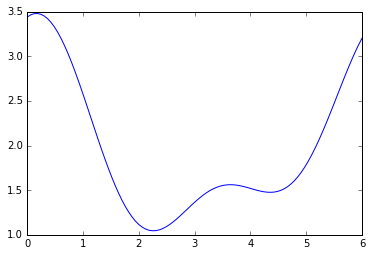

In [3]:
# Our black-box function for today.

import numpy as np
import matplotlib.pyplot as plt
from utils import black_box

all_x = np.reshape(np.linspace(0, 6, 100), (-1, 1))
all_f = [black_box(xi) for xi in all_x]
plt.plot(all_x, all_f)
plt.show()


### High level usage

```python
import numpy as np

from skopt import gp_minimize
from utils import black_box

# Provide initial points from 5.0 - 6.0, away from the original minimum.
x0 = np.reshape(np.linspace(5.0, 6.0, 10), (-1, 1)).tolist()
y0 = [black_box(xi) for xi in x0]

# Search for minimum from 0.0 - 6.0
dimensions = [[0.0, 6.0],]

# Optimize!
res = gp_minimize(
    black_box,
    dimensions=dimensions,
    x0=x0,
    y0=y0,
    n_random_starts=0,
    n_calls=4,
    random_state=0
)

print(res["x"])
[2.441]
```

### Let's go one level deeper

```python
from skopt.optimizer import Optimizer
from skopt.learning import GaussianProcessRegressor

# Search from 0.0 to 6.0
dimensions = ((0.0, 6.0),)

# Initialize estimator.
gpr = GaussianProcessRegressor(kernel=Matern(), noise=0.0)
optimizer = Optimizer(
    dimensions=dimensions,
    base_estimator=gpr,
    n_random_starts=0,
    acq_func="LCB",
    random_state=0)
```

### Tell some points and ask for a point

```python
# Plotting search space with previously seen points, candidate point and acquisition values
from utils import plot_space
from utils import black_box

# As before use points from 5.0 to 6.0
X = np.reshape(np.linspace(5.0, 6.0, 10), (-1, 1)).tolist()
y = [black_box(xi) for xi in X]
optimizer.tell(X, y)
x_cand = optimizer.ask()
y_cand = black_box(x_cand)
plot = plot_space(X, y, optimizer.models[-1], x_cand)
plot.show()
```

<img align="center" src="images/cand1.png"></img>

### Tell and ask again!

```python
# Tell and ask again.
optimizer.tell(x_cand, y_cand)
X = X + [x_cand]
y = y + [y_cand]
x_cand = optimizer.ask()
y_cand = black_box(x_cand)
plot = plot_space(X, y, optimizer.models[-1], x_cand)
plot.show()
```

<img align="center" src="images/cand2.png"></img>

### Tell and ask again!

```python
# Tell and ask again.
optimizer.tell(x_cand, y_cand)
X = X + [x_cand]
y = y + [y_cand]
x_cand = optimizer.ask()
y_cand = black_box(x_cand)
plot = plot_space(X, y, optimizer.models[-1], x_cand)
plot.show()
```

<img align="center" src="images/cand3.png"></img>

### More deeper:

### Predictive model

- Should provide a predictive distribution $P(Y | X)$ at every point.
- Cheap approximation to the actual function.
- Provides information about the variance in the function approximation.
- Examples: Gaussian Processes, Random Forests

Will focus on Gaussian Processes on the rest of this talk, though Random Forests are highly useful when there a high number of categorical variables.


### Gaussian Processes - Training


- Assume the points $D = (X_1, y_1), (X_2, y_2), ... (X_N, y_N)$ are obtained from the black box.

- Recenter the points $y_i$ such that the mean is zero.

- Now the assumption is that $y$ forms a multivariate normal distribution. 

- Mean of size $N$ given by the origin.

- The covariance matrix $K^D$ is computed by a kernel $K$.

- Each element $K^D_{ij}$ is given by $K(X_i, X_j)$

### Gaussian Processes - What to train?

- Different kernels hold different assumptions about the smoothness of the functions.

- Available kernels in skopt can be seen [here](https://github.com/scikit-optimize/scikit-optimize/blob/master/skopt/learning/gaussian_process/kernels.py)

- Also, different covariance matrices have different (hyper)parameters.

- For example, the squared exponential kernel has a different length scale for each dimension.

- In the sklearn implementation, "best" parameters are obtained by maximizing the log-likelihood on training data

### Gaussian Processes - Prediction

- For new points, the posterior is also multivariate gaussian.

- This gives not only a prediction but also a probability distribution for every new point.

### Code example

```python
# Import necessary stuff
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF

# Evenly spaced points from 0-6
all_x = np.reshape(np.linspace(0, 6, 100), (-1, 1))
all_f = [black_box(xi) for xi in all_x]
plt.plot(all_x, all_f)

# Fit on only one third of the training data.
X = np.reshape(np.linspace(0, 10, 10), (-1, 1))
y = [black_box(xi) for xi in X]

# Use RBF kernel.
rbf = RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=1e-12)
gpr.fit(X, y)
plt.plot(np.ravel(X), y, "ro", label="True function")

# Predict on all data to obtain uncertainty estimates
y_pred, y_std = gpr.predict(all_x, return_std=True)
all_x_plot = np.ravel(all_x)
upper_bound = y_pred + 1.96*y_std
lower_bound = y_pred - 1.96*y_std

plt.plot(all_x_plot, y_pred, "r--", label="Predictions")
plt.plot(all_x_plot, lower_bound, color="red")
plt.plot(all_x_plot, upper_bound, color="red")
plt.fill_between(all_x_plot, lower_bound, upper_bound, facecolor="lightcoral")
plt.legend()
plt.show()
```

<img align="center" src="images/gpr.png"></img>


### Acquisition functions

- Combines information about the best values (known) and uncertainty information (unknown).
- Tradeoff between exploration and exploitation.
- Popular acquisition functions include LCB(Lower Confidence Bound) and EI(Expected Improvement)


### Lower Confidence Bound

- $A(x) = \mu(x) - \kappa \sigma(x)$
- $\kappa$ controls exploitation vs exploration


### Expected Improvement
- $A(x) = E_{f(x)}(u(f(x)))$
- $u(f) = 0$, if $f(x) > f^*$
- $u(f) = f^* - f$ otherwise
- Available in closed form!
- Awards proportional to the amount of improvement over the best value.

### Code example

```python
from skopt.acquisition import gaussian_ei
from skopt.acquisition import gaussian_lcb

ei_vals = -gaussian_ei(all_x, gpr, y_opt=np.min(y))
lcb_vals = gaussian_lcb(all_x, gpr)

plt.plot(all_x_plot, ei_vals, "b", label="-EI")
plt.plot(all_x_plot, lcb_vals, "black", label="LCB")

```

<img align="center" src="images/acquisition.png"></img>

### Optimising the acquisition function

- Calling the acquisition function no longer expensive.
- Can now be optimised using other techniques.

### How does scikit-optimize handle this?
- Default is multi-start lbfgs.
- Start points are obtained by the "best" points on a uniform-grid
- More advanced techniques like entropy-search, DIRECT (soon in skopt)


### Website

https://scikit-optimize.github.io/

### Issue tracker
https://github.com/scikit-optimize/scikit-optimize/issues

# Any questions?